<h2>Daniel Vasilyonok</h2>
<h3>Python for Data Science CSCI E - 29</h3>
<h3>Natural Language Identification Machine Learning Pipeline - Graduate Project</h3>

<p>
In this project, I pulled text data from European Parliament Proceedings in 21 languages.
Using Scikit-Learn, I transformed the raw text into a numerical feature matrix, and trained
a Multinomial naive bayes probability model to classify input language with greater than 99% accuracy.
</p>

<p> 
Data Source: http://www.statmt.org/europarl/    
</p>

In [4]:

# Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [5]:

# regular expression pattern used to filter out anything between < >
# Non predictive speaker information in english is always in between those two symbols

pattern = r'<(!?).*>'

# Max length of language transcription
# Ensure each language has similar amount of representation (Balanced Dataset)
MAX_LENGTH_TRANSCRIPTION = 150000

In [6]:

# Map language index to natural language

labels = { 
          1.0:'Danish', 2.0:'German',
          3.0: 'Greek', 4.0: 'English', 
          5.0: 'Spanish',6.0: 'Finnish', 
          7.0: 'French', 8.0: 'Italian', 
          9.0: 'Dutch', 10.0: 'Portuguese', 
          11.0: 'Swedish', 12.0: 'Bulgarian',
          13.0: 'Czech', 14.0: 'Estonian',
          15.0: 'Hungarian', 16.0: 'Lithuanian',
          17.0: 'Latvian', 18.0: 'Polish',
          19.0: 'Romanian', 20.0: 'Slovak',
          21.0: 'Slovenian'
          }

# Map language to language code and file name

language_codes_files = {
    'Danish': ['da', '/ep-00-01-17.txt'], 'German': ['de', '/ep-00-01-17.txt'], 
    'Greek': ['el', '/ep-00-01-17.txt'], 'English': ['en', '/ep-00-01-17.txt'], 
    'Spanish': ['es', '/ep-00-01-17.txt'], 'Finnish': ['fi', '/ep-00-01-17.txt'],
    'French': ['fr','/ep-00-01-17.txt'], 'Italian': ['it', '/ep-00-01-17.txt'], 
    'Dutch': ['nl', '/ep-00-01-17.txt'], 'Portuguese': ['pt', '/ep-00-01-17.txt'], 
    'Swedish': ['sv', '/ep-00-01-17.txt'], 'Bulgarian': ['bg', '/Bulgarian.txt'],
    'Czech': ['cs', '/Czech.txt'], 'Estonian': ['et', '/Estonian.txt'],
    'Hungarian': ['hu', '/Hungarian.txt'], 'Lithuanian': ['lt', '/Lithuanian.txt'],
    'Latvian': ['lv', '/Latvian.txt'], 'Polish': ['pl', '/Polish.txt'],
    'Romanian': ['ro', '/Romanian.txt'], 'Slovak': ['sk', '/Slovak.txt'],
    'Slovenian': ['sl', '/Slovenian.txt']
}

# These languages need multiple files combined to get a transcription of length
# >= MAX_LENGTH_TRANSCRIPTION
limited_raw_text = ['Bulgarian', 'Czech', 'Estonian', 'Hungarian', 'Lithuanian',
                     'Latvian', 'Polish', 'Romanian', 'Slovak', 'Slovenian']


In [7]:
# Helper Functions

def combine_text_files(language_code, language):
   
    '''
    Goal: Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
          This function will combine these files for this sort of language into one language
          transcription, and then write the transcription to a single file.
    
    @param: (string) language_code is the 2 character code of the language
    @param: (string) language is the English name of the language         
    '''    
    
    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if(len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path) as f:
            contents = f.read()
            language_transcription += contents
    
    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w') as f:
        f.write(language_transcription)

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
                 Original file data source found here: http://www.statmt.org/europarl/
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path) as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern,'',sentence)

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of strings that has had speaker information filtered out
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0],1)
    target = np.zeros((sentences.shape[0],1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def shuffle_rows(languages):
    '''
    Goal: Shuffle rows of 2D np.array with language data
    
    @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
    @return shuffled_languages: shuffled by row, 2D np.array 
    '''
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index,:]
    return shuffled_languages
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict( (key, language_codes_files[key] ) for key in limited_raw_text if key in language_codes_files )
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)
    
    # Read all raw text data from file paths
    language_transcriptions = [ read_languages_data(path) for path in file_paths ]
    
    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)
    
    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)
    
    # Combine each language with its language_index
    languages = [ combine_language_data(sentences,i+1) for i,sentences in enumerate(language_transcriptions) ]
    
    # Vertically stack all data into one 2D np.array
    languages =  np.vstack((languages))
    
    # Shuffle languages by row
    languages = shuffle_rows(languages)
    
    return languages
    

In [8]:
# Get all file paths

file_paths = [ os.getcwd() + '/language_data/txt/' + language_codes_files[language][0] + language_codes_files[language][1] for language in language_codes_files ]

# Preprocess all raw text into a form suitable for TfidfVectorizer
languages = preproccess_raw_data(file_paths)
languages

array([[ 'V druhé řadě vyzývám vysokého představitele, aby předložil odůvodněné stanovisko k iniciativě obsažené v této rezoluci.',
        '13.0'],
       [ 'Тези недостатъци трябва да бъдат преодолени неотложно, особено след събитията от 7 април.',
        '12.0'],
       [ '\nDesidero ora rispondere ad alcune delle osservazioni degli onorevoli parlamentari, innanzi tutto sulla procedura.',
        '8.0'],
       ..., 
       [ '\nÉ esse o motivo por que aprovo, com todo o prazer, o facto de a Comissão ir deixar a cargo dos Estados\xadMembros e das regiões a elaboração e execução práticas das medidas em questão.',
        '10.0'],
       ['Hyväksymme siis meille ehdotetut neljä tarkistusta.', '6.0'],
       [ '\nMa olen saanud kuus resolutsiooni ettepanekut vastavalt kodukorra artikli 108 lõikele 5.',
        '14.0']],
      dtype='<U1252')

In [9]:
languages.shape

(20945, 2)

In [10]:
# Split data into raw features and labels

language_features = languages[:,0]
language_targets = languages[:,1]

Ensure Dataset is relativley balanced.

In [11]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{'1.0': 1063,
 '10.0': 814,
 '11.0': 975,
 '12.0': 1030,
 '13.0': 1161,
 '14.0': 1184,
 '15.0': 1019,
 '16.0': 1213,
 '17.0': 1174,
 '18.0': 1121,
 '19.0': 958,
 '2.0': 912,
 '20.0': 1163,
 '21.0': 1173,
 '3.0': 760,
 '4.0': 890,
 '5.0': 860,
 '6.0': 880,
 '7.0': 815,
 '8.0': 802,
 '9.0': 978}

In [12]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [13]:
'''
       Machine Learning Pipeline

    1. Preprocess raw sentence features with TfidfVectorizer. Convert raw sentence text into numerical feature matrix.
       TfidfVectorizer is the combination of CountVectorizer, and TfidfTransformer.
       TfidfVectorizer : tfidf = Term frequency inverse document frequency 
                      
                         analyzer = 'char', the raw sentence feature is tokenized into characters
                         ngram_range = (1,3), character n_grams are formed with character length
                                              from 1 to 3
                      
                         The count of each ngram is recorded and divided 
                         by the total ngrams in the sentence (CountVectorizer) This is term frequency.
                         This term frequency is scaled down by being multiplied by how common it is in all sentences,
                         i.e. by 1 + log(# sentences / # of sentences that contain the ngram). 
                         If an ngram is highly recurrent in the sentences the value of the above log ratio 
                         approaches 0, and lowers the tfidf score.
                      
                         The resulting feature matrix has the sentence/row index, and the ngram_index along with
                         its tfidf score. This can be passed into the model.
                      
    2. Naive Bayes MultinomialNB model
       Features are assumed to be generated from a simple multinomial distribution. 
       The data is modeled with best fit multinomial distribution.
       The multinomial distribution describes the probability of observing counts among a number of categories.
       Thus, this model is a good fit for observing count frequency of ngrams as represented by tfidf scores.
    
'''

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [14]:

# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [15]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [16]:

# Measure accuracy

accuracy_score(y_test,predictions)

0.99363462762571608

<h1>Cross Validated Accuracy</h1>

In [17]:

# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.991117282223


<h1>Classification Report</h1>

In [18]:
# Target order based on ordering of default classification report
targets = ['Danish', 'Portuguese', 'Swedish',
           'Bulgarian', 'Czech', 'Estonian',
           'Hungarian', 'Lithuanian', 'Latvian',
           'Polish', 'Romanian', 'German', 
           'Slovak', 'Slovenian', 'Greek', 
           'English', 'Spanish', 'Finnish', 
           'French', 'Italian', 'Dutch']

In [19]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        1.0       0.99      0.99      0.99       322
       10.0       1.00      1.00      1.00       253
       11.0       0.98      0.99      0.98       290
       12.0       1.00      1.00      1.00       294
       13.0       0.99      0.98      0.99       367
       14.0       0.99      1.00      0.99       364
       15.0       1.00      0.99      0.99       295
       16.0       0.99      0.99      0.99       365
       17.0       1.00      0.99      1.00       344
       18.0       1.00      0.99      0.99       328
       19.0       0.99      1.00      1.00       286
        2.0       1.00      1.00      1.00       263
       20.0       0.99      0.98      0.98       364
       21.0       0.99      1.00      0.99       345
        3.0       1.00      1.00      1.00       231
        4.0       1.00      1.00      1.00       256
        5.0       1.00      0.99      0.99       298
        6.0       1.00      0.99      0.99   

In [20]:

print(classification_report(y_test, predictions, target_names=targets))

             precision    recall  f1-score   support

     Danish       0.99      0.99      0.99       322
 Portuguese       1.00      1.00      1.00       253
    Swedish       0.98      0.99      0.98       290
  Bulgarian       1.00      1.00      1.00       294
      Czech       0.99      0.98      0.99       367
   Estonian       0.99      1.00      0.99       364
  Hungarian       1.00      0.99      0.99       295
 Lithuanian       0.99      0.99      0.99       365
    Latvian       1.00      0.99      1.00       344
     Polish       1.00      0.99      0.99       328
   Romanian       0.99      1.00      1.00       286
     German       1.00      1.00      1.00       263
     Slovak       0.99      0.98      0.98       364
  Slovenian       0.99      1.00      0.99       345
      Greek       1.00      1.00      1.00       231
    English       1.00      1.00      1.00       256
    Spanish       1.00      0.99      0.99       298
    Finnish       1.00      0.99      0.99   

In [21]:
language_names = list(language_codes_files.keys())
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(targets)
ax.set_yticklabels(targets)

[Text(0,0.5,'Danish'),
 Text(0,1.5,'Portuguese'),
 Text(0,2.5,'Swedish'),
 Text(0,3.5,'Bulgarian'),
 Text(0,4.5,'Czech'),
 Text(0,5.5,'Estonian'),
 Text(0,6.5,'Hungarian'),
 Text(0,7.5,'Lithuanian'),
 Text(0,8.5,'Latvian'),
 Text(0,9.5,'Polish'),
 Text(0,10.5,'Romanian'),
 Text(0,11.5,'German'),
 Text(0,12.5,'Slovak'),
 Text(0,13.5,'Slovenian'),
 Text(0,14.5,'Greek'),
 Text(0,15.5,'English'),
 Text(0,16.5,'Spanish'),
 Text(0,17.5,'Finnish'),
 Text(0,18.5,'French'),
 Text(0,19.5,'Italian'),
 Text(0,20.5,'Dutch')]

<h1> 21x21 Confusion Matrix</h1>

<p> 
The well defined diagonal is a visual representation 
of the good performance of this language classifier.
Although this model performs quite well, there are a few misclassifications.
The confusion matrix gives insight into where the model makes errors.
It's interesting to note that errors usually occur among languages from a related language
family. For example, the model predicts Slovak 3 times when the actual language is Czech, and
it predicts Czech 3 times when the actual language is Slovak. There are some weird cases where 
the model predicts a language that's not from a similar family, and this could be the cause of a small amount of labeled bad data that was not cleaned from the raw dataset.
</p>

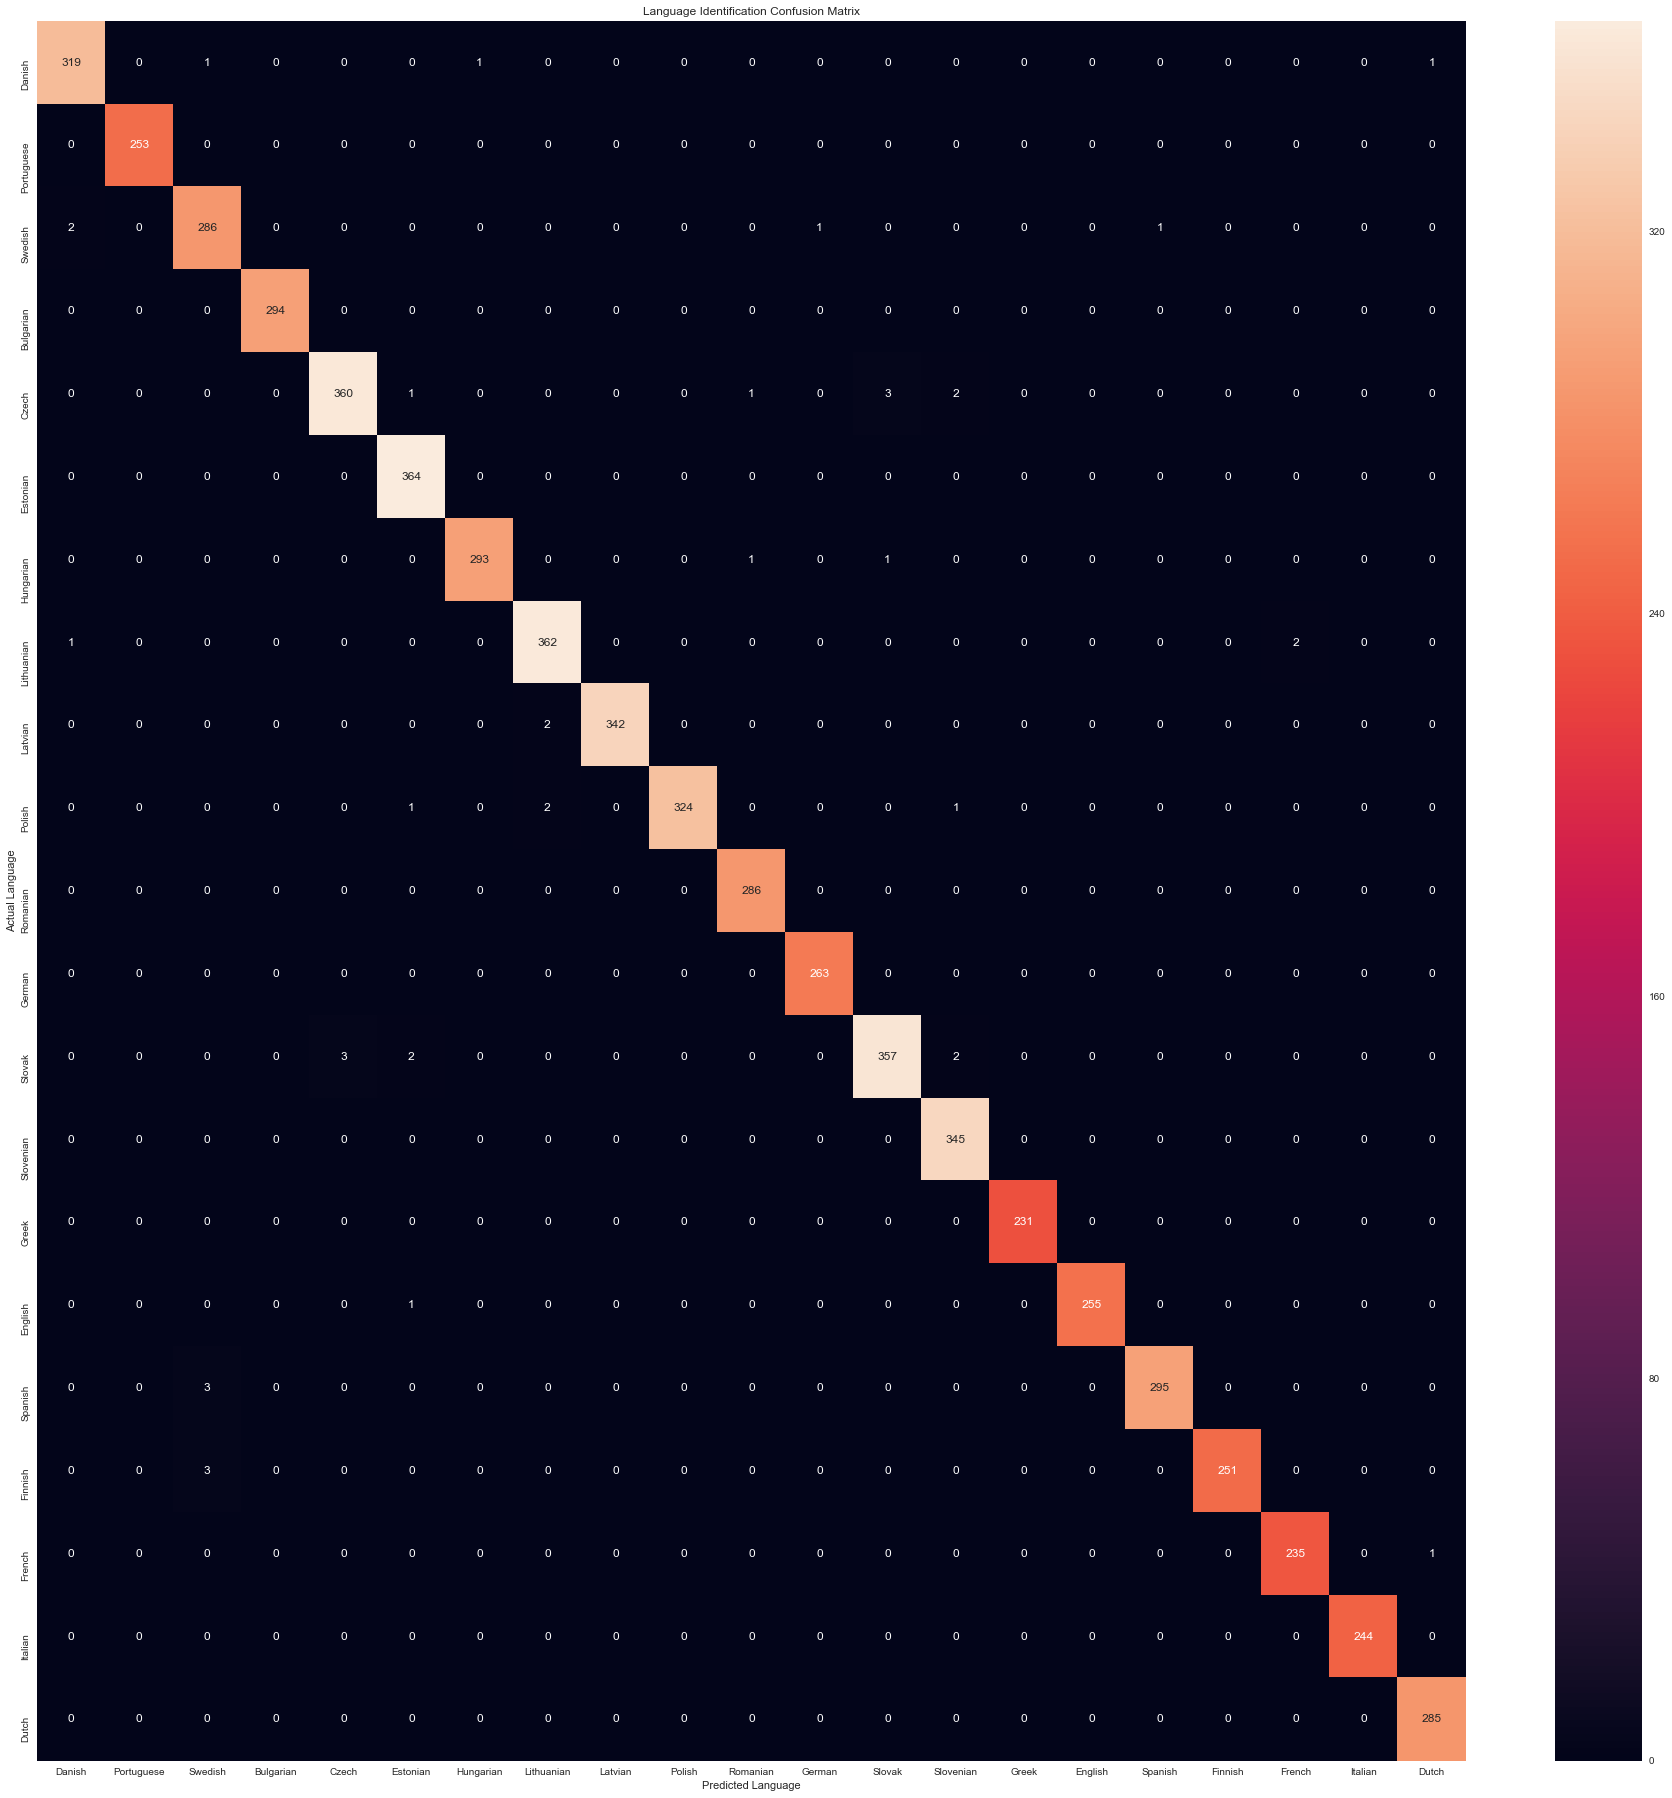

In [22]:
plt.show()

In [23]:
# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
el Sr. Comisario se encuentra aquí, había creído que usted no vendría.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Mums vajadzīgs NU munīcijas ražošanas un izmantošanas aizliegums.


Prediction: English
Actual Language: English
Input Sentence: 

The key goal of the structural funds is to strengthen social and economic cohesion between the regions within the European Union.


Prediction: Czech
Actual Language: Czech
Input Sentence: 

Rumunsko provádí a bude nadále provádět proaktivní politiku zamířenou na podporu integrace Moldavské republiky do evropských struktur.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Čo sa tejto témy týka, Komisia pokračuje v práci na návrhu zdanenia finančných činností.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Podjął Pan to wyzwanie wspólnie z panem przewodniczącym Van Rompuyem.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
S

Actual Language: Greek
Input Sentence: 

Αξιότιμε κύριε Πρόεδρε, αξιότιμοι συνάδελφοι, καλή χρονιά και καλή χιλιετία.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

Rozdiely v konkurencieschopnosti sú skutočným problémom pre tie krajiny, ktoré majú spoločnú menu.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Комисията ще положи всички усилия, за да постигне тази цел.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Dabar tikrai žinome, kad šis dokumentas buvo ir kad buvo skirtas tam tikram įdomiam aiškinimui.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 

A harmadik és egyben utolsó kérdés, hogy Ön szerint hogyan leszünk képesek ismét kiépíteni a bizalmat, amikor minden monetáris politikai döntésünkkel - illetve az Európai Központi Bank legutóbbi döntéseivel - tovább romboljuk a legveszélyeztetettebb országok növekedési potenciálját?


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Krīzes la

Actual Language: Czech
Input Sentence: 

Proto problém, s nímž se musíme vypořádat, je problémem evropským.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

Chcel by som upozorniť na jeden konkrétny bod.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

O relatório propriamente dito é bem intencionado mas, como frequentemente acontece quando tratamos estas questões, carece de clareza de objectivos e de uma sólida base de operacionalidade.


Prediction: German
Actual Language: German
Input Sentence: 

Frau Präsidentin, zunächst möchte ich Herrn Koch für seinen Bericht danken, der die Verkehrssicherheit zum Thema hat.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Tai labai svarbu siekiant užtikrinti objektyvumą ir nepriklausomumą kontroliuojant valstybių narių pastangas, bendrosios rinkos vientisumą ir visą acquis communautaire bei skirtumą tarp iniciatyvų, kurių imamasi euro zonoje, ir iniciatyvų, kurios vykdomos visoje Europos 

Actual Language: Czech
Input Sentence: 
Obvinění, která moldavské úřady vznesly proti rumunskému státu, jsou nesmyslná.


Prediction: Polish
Actual Language: Polish
Input Sentence: 

Bardziej niepokojące są doniesienia o nagminnych naruszeniach praw człowieka w reakcji na demonstracje po wyborach.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Se tarkoittaa, että kaikki ryhmät sitoutumattomia jäseniä lukuun ottamatta - mutta hehän eivät olekaan mitään ryhmiä - olivat yksimielisiä ja vain teidän ryhmänne kannatti sellaista menettelyä, jota te olette täällä ehdottanut.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Musimy pracować wespół z władzami, opozycją i społeczeństwem obywatelskim, lecz także z Rosją, której obecność w regionie jest bardzo ważna.


Prediction: French
Actual Language: French
Input Sentence: 

Il ne fait aucun doute que les politiques structurelles et la politique de cohésion de l'Union européenne sont les outils de base pour créer le

Actual Language: Finnish
Input Sentence: 
Me joudumme näin ollen rakentamaan saman maan samoille ihmisille moneen kertaan koulut, sairaalat, koko infrastruktuurin uudelleen.


Prediction: German
Actual Language: German
Input Sentence: 
Sie ergibt sich aufgrund unserer Entfernung, unserer Insellage, kurz, unsere Eigenheit schafft diese Situation.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
UE odgrywała między innymi ważną rolę w trakcie drugiej konferencji badawczej w 2006 r. i będzie również działać aktywnie przez okres trwania programu specjalistycznego, do czasu następnej konferencji badawczej, zaplanowanej na 2011 r.

Jeśli chodzi o konwencję o broniach konwencjonalnych, zarówno Unia Europejska, jak i jej państwa członkowskie uczestniczą czynnie w bieżących negocjacjach, poświęconych społecznym następstwom użycia bomb kasetowych.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Bilo bi popolnoma neodgovorno do držav s visokim javnim ali zasebnim 

Prediction: Polish
Actual Language: Polish
Input Sentence: 
Chciałabym przyłączyć się do tych, którzy wyrazili uznanie dla pana przewodniczącego Barroso za sposób, w jaki podjął wyzwanie i przybył tu, żeby nam wyjaśnić istotę paktu na rzecz konkurencyjności; dziś udało się nawet wprawić pana posła Schulza w dobry nastrój.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Kako bomo povezali pakt za konkurenčnost s strategijo EU 2020?


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Несъмнено е постигнат значителен напредък, но противодействието на неравенството между половете е ежедневна задача и все още ни предстои да изминем дълъг път.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Valstybės ir Ministrai Pirmininkai neketina patys reguliuoti!


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Musimy dokonać rozróżnienia między oświadczeniami prezydenta Woronina i działaniami przedstawicieli politycznych z jednej st

Actual Language: English
Input Sentence: 

The debate is closed.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Myös havainto, että alueiden väliset erot jäsenvaltioiden sisällä joskus jopa lisääntyvät, herättää vakavia kysymyksiä.


Prediction: French
Actual Language: French
Input Sentence: 
Les services compétents ne les ont pas inclues à l'ordre du jour, avançant que des réponses avaient déjà été apportées lors d'une précédente session.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Opoziţia a indicat şi exploatarea extinsă a resurselor administrative de către partidul la putere pe durata campaniei electorale.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

É importante para nós que a Comissão tenha em conta as conclusões que se aprovem neste Parlamento, pelo menos, o seu espírito, porque, na altura em que estamos, poderia parecer que estamos a fazer aqui um exercício inútil, de pura retórica.


Prediction: Italian
Actual La

Input Sentence: 

Durante la preparazione della relazione è stato interessante discutere dei temi generali relativi alla politica regionale dell'Unione europea.


Prediction: German
Actual Language: German
Input Sentence: 
Sehr geehrte Kollegen!


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Igal juhul antakse ideed edasi ja vabatahtlikkuse vaim moodustab protsessist ühe osa, uskuge mind, sest peame selgelt lootma, et kõik teised Euroopa riigid suudavad teha seda, mida Belgia on teinud.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Nieustannie dajemy dowody, że o niej pamiętamy, czy to w sprawach dotyczących rynku wewnętrznego, konkurencji, czy też zwalczania dyskryminacji.


Prediction: Greek
Actual Language: Greek
Input Sentence: 

Η λειτουργία του προηγούμενου γύρου προγραμμάτων είναι επίσης πολύ διδακτική, αφού μας λέει τι δεν πρέπει να περιλαμβάνουν οι κατευθυντήριες γραμμές.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Nõuko

Actual Language: Slovenian
Input Sentence: 

Lahko vam zagotovim, da Komisija počne vse, kar je v njeni moči, da spodbudi ambicioznost.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

Keďže ste spomenuli trvalo udržateľný rast, pán Barroso, dovoľte mi dodať ešte jednu poznámku.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Ezerszám vannak arctalan civilek, akik még mindig a sugárszennyezett területeken élnek és halnak meg: Irakban Afganisztánban, Koszovóban, Boszniában, Szomáliában úgy, hogy sejtelmük sincs sorsukról.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Me emme halua huonontaa yksipuolisesti joidenkin maiden kilpailuedellytyksiä ja parantaa niitä Itävallan kaltaisten maiden tai muiden kauttakulkumaiden kohdalla.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Kľúčom k budúcej stabilite a prosperite Moldavska je prehĺbenie jeho vzťahu s Európskou úniou.


Prediction: Slovak
Actual Language: Slovak
Input Sente


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Hyväksymme siis meille ehdotetut neljä tarkistusta.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Krize jasně ukázala, že je třeba konzistentních a ambiciózních opatření pro posílení demokratických norem a institucí v Moldavsku.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 

Huvudmålsättningen för strukturfonderna är att öka den sociala och ekonomiska sammanhållningen mellan regionerna inom Europeiska unionen.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

Tretje in zadnje vprašanje je, kako bomo po vašem mnenju ponovno vzpostavili zaupanje, ko pa vse odločitve glede denarne politike - zadnje najočitnejše so bile odločitve Evropske centralne banke -, ki dolgoročno ogrožajo rast, še naprej škodijo najranljivejšim državam?


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 

Излизането от кризата изисква например дейността на постоянния фонд да вземе под вн

Prediction: Romanian
Actual Language: Romanian
Input Sentence: 

Parlamentul European s-a situat în mod consecvent într-o poziţie de frunte în ceea ce priveşte solicitarea măsurilor împotriva practicilor tradiţionale dăunătoare.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
A 27-ek költségvetési prioritásai tekintetében ez évben elért együttműködés már önmagában is hatalmas attitűdváltozást jelent.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Pokud jsou hlavy států či předsedové vlád nyní ochotni zapojit se do koordinace hospodářských politik, a to dokonce i v některých oblastech, které se doposud považovaly za výlučnou oblast působnosti pravomoci členských států, domnívám se, že by to mělo být přivítáno potud, pokud to respektuje systémy správy Společenství.


Prediction: German
Actual Language: German
Input Sentence: 
Meine Änderungsanträge betreffen die Frostbeständigkeit der Transportbehälter für Gefahrgut.


Prediction: Bulgarian
Actual Languag

Actual Language: Estonian
Input Sentence: 
Nad mõlemad on osavad strateegid.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

En primer lugar: el informe analiza el efecto del instrumento como tal.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Puedo vivir con estas normas mínimas, pero pido a la Comisión que haga un seguimiento real y cuidadoso de las cosas.


Prediction: French
Actual Language: French
Input Sentence: 
Combien de temps entendons-nous donc accepter cette évolution qui aboutit à l'augmentation de la fracture entre les régions pauvres et riches ?


Prediction: Czech
Actual Language: Czech
Input Sentence: 

(Předsedající řečníka přerušila)

Paní předsedající, má země, Irsko, je malou otevřenou ekonomikou, která se silně soustřeďuje na přímé zahraniční investice.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

Kmalu po izbruhu nasilnih protestov v Kišinevu 7. aprila je EU poslala posebnega predstavnika Kalmana Mizseija 

Input Sentence: 
Stanno crescendo in termini di competitività, ma non tutti possono godere della crescita della ricchezza, perché non aumenta l' occupazione e permane un divario nelle opportunità occupazionali tra le varie regioni.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Kellele me aga selle eest tänu võlgneme?


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
A mohol by som dodať: veľmi hrdú úniu.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
85 milijonov Evropejcev živi pod pragom revščine in ocene kažejo, da v revščini živi kar 17 % vseh žensk v EU.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Och det är det som gör att vi kan rösta för den.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
NATO izmantoja NU munīciju savā agresīvajā karā pret Dienvidslāviju.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Skaidri jāpasaka, ka vēl nav radusies noteikta atbilde.


Prediction: E

Input Sentence: 
Dėl besitęsiančių politinių neramumų šaliai nepavyktų išspręsti ekonominių problemų.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Niekada anksčiau Europos Parlamente šis skaičius nebuvo toks didelis.


Prediction: Czech
Actual Language: Czech
Input Sentence: 

jménem skupiny EFD.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Moneda unică nepotrivită pentru obiectivele lor, monedă care a fost creată pe baza unei ideologii idealiste, nu pe o judecată economică.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
A program kudarca hozzájárul a tágabb értelemben vett euróövezet pénzügyi labilitásához.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Jeg kommer ligesom vores kollega Rack fra et transitland, hvor dette spørgsmål spiller en særlig rolle.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

Arvoisa puhemies, jos sallitte, haluaisin ensiksi ilmaista teille kunnioitukseni siitä



Prediction: English
Actual Language: English
Input Sentence: 
I find the opposite the case.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Vista l' imminenza delle elezioni europee, in pratica il Parlamento ha potuto intraprendere l' esame delle linee direttrici soltanto nel luglio 1999, quando il testo era stato già adottato in via definitiva.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Chiedo alla Commissione che le linee direttrici, che certamente sono uno strumento dotato di sufficiente flessibilità, rappresentino effettivamente il criterio alla base dei negoziati.


Prediction: German
Actual Language: German
Input Sentence: 

Deshalb begrüße ich es, wenn die Kommission die praktische Ausarbeitung und die Durchführung von Maßnahmen den Mitgliedstaaten und Regionen überläßt.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Nemožno poprieť, že účasť žien na trhu práce môže byť pre hospodársky rast len prospešná.


Prediction: Englis

Input Sentence: 

(Ръкопляскания)

(EN) Г-жо председател, това просто не е вярно и не се подкрепя от статистическите данни в моята страна.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 

Ik wil erop wijzen, mevrouw de Voorzitter, dat dat debat zich volgens het in septembere bereikte akkoord zou onderscheiden van het debat over het jaarlijks wetgevingsprogramma van de Commissie.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
A menudo se han concedido fondos para proyectos que no han dejado ningún beneficio permanente en la zona de realización.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
En cambio, los ciudadanos de varios de nuestros países han sido víctimas de catástrofes naturales verdaderamente terribles.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Vi havde en udførlig debat på Formandskonferencen.


Prediction: French
Actual Language: French
Input Sentence: 
En déplaçant les critères des régions aux États membres, o

Actual Language: Italian
Input Sentence: 

Onorevoli parlamentari, nell' Unione europea si constata un divario inferiore tra i paesi, il che dimostra l' efficacia e l' utilità del Fondo di coesione, ma al contempo si osserva - come scrive la relatrice - che in materia di disoccupazione lo scarto tra le 15 o 20 regioni più ricche e le 15 o 20 regioni più povere o più diseredate si fa sempre maggiore e tale situazione è e rimane ingiustificabile e intollerabile.


Prediction: German
Actual Language: German
Input Sentence: 

Frau Schroedter, Sie haben zu Recht daran erinnert, daß es im wesentlichen Aufgabe der Mitgliedstaaten und der Regionen ist, ihre eigenen Entwicklungsprioritäten festzulegen.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Как ще обвържем пакта за конкурентоспособност със стратегията "ЕС 2020"?


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Minu arvates on tegemist väga tõsise küsimusega.


Prediction: Polish
Actual Language: Pol

Actual Language: Spanish
Input Sentence: 

(El Parlamento, de pie, guarda un minuto de silencio)


Señora Presidenta, una cuestión de procedimiento.


Prediction: Romanian
Actual Language: Czech
Input Sentence: 

2.


Prediction: French
Actual Language: French
Input Sentence: 
Nous nous opposons à l' interventionnisme de l' administration centrale de l' Union et de celle des États membres et nous demandons une réduction de la bureaucratie qui s' est incrustée dans l' élaboration et la réalisation des programmes.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Då åberopade medlemsländernas regeringar subsidiaritetsprincipen och ville helt enkelt få sig pengarna tillskickade.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Dvanajst in pol odstotkov davka od dobička pravnih oseb je ključnega pomena pri podpori našemu gospodarskemu okrevanju, ohranjanju delovnih mest in rasti zaposlovanja.


Prediction: Czech
Actual Language: Czech
Input Sentence: 

Za o

Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Kolleeg Farage muidugi nii ei arva, kuid kõigi teiste jaoks on see samm edasi.


Prediction: French
Actual Language: French
Input Sentence: 
C' est une circonstance particulière qui exige que l' on prenne aussi en considération l' effet que peuvent avoir ces températures très basses sur les marchandises et leurs emballages.


Prediction: Greek
Actual Language: Greek
Input Sentence: 

Διάταξη τωv εργασιώv

Η ημερήσια διάταξη προβλέπει την εξέταση του τελικού σχεδίου της ημερήσιας διάταξης έτσι όπως καταρτίστηκε από τη Διάσκεψη των Προέδρων, την Πέμπτη 13 Ιανουαρίου, συμφώνως προς το άρθρο 110 του Κανονισμού.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
For så vidt angår denne håndhævelse, skal der også indgås ordentlige aftaler med de østeuropæiske lande, for først fra 1. juli 2001, altså om halvandet år, vil man der tiltræde de traktater, som vedrører dette.


Prediction: Dutch
Actual Language: Dutch
Input

Input Sentence: 

A Moldovai Köztársaság a szomszédunk.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
V Iraku so ameriške sile uporabile skupno 300 ton streliva z osiromašenim uranom.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Met betrekking tot het fiscale aspect, de overheidssteun, de structuurfondsen en de bescherming van onze traditionele producten moeten er snel concrete maatregelen worden bedacht die zich kenmerken door moed en ambitie.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 

Ik wil kort reageren op het voorstel van de Commissie om de richtlijn inzake het vervoer van gevaarlijke goederen over de weg te herzien.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
V každom prípade budem ďalej so záujmom sledovať diskusiu na túto tému.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Proto vás všechny vyzývám k podpoře tohoto usnesení.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Ļoti


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Ние проверяваме законността на това действие.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Desuden skal der lægges større vægt på en styrkelse af igangsætterpotentialet i små og mellemstore virksomheder, og tjenesteydelserne for SMV skal videreudvikles.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Szokás szerint ebben a drámában sincs hiány fő- és mellékszereplőkből, valamint puszta statisztákból.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Това не е просто вътрешен проблем или проблем на отделна държава-членка.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
Todavia, o que devíamos fazer era dar prioridade sobretudo aos aspectos da segurança no transporte de mercadorias, caminho­de­ferro e vias navegáveis, que fazem parte do acervo, adoptá­los o mais rapidamente possível e apresentá­los aos países candidatos à adesão.


Prediction: Po



Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Usein varoja on myönnetty hankkeisiin, joista ei ole jäänyt mitään pysyvää hyötyä alueelle.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Mums no visa sava spēka jācīnās pret postu, ko rada pret sievietēm vērsta vardarbība visās tās izpausmes formās.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Invito a todos a que nos pongamos de pie para guardar un minuto de silencio.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Obaja sú veľmi šikovní stratégovia.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
In het voorkomende geval kan dat dan leiden tot concrete specificaties en vereisten bij technische normaliseringsactiviteiten of typebeschrijvingen.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

V prvom rade by som rád poďakoval spravodajkyniam z Výboru pre práva žien a rodovú rovnosť a s pridruženého Výboru pre zamestnanosť a sociálne veci, ktoré s